In [1]:
import math
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
#plt.rcParams.update({'font.size': 12})
from matplotlib import font_manager
font_manager.fontManager.addfont('../misc/lucida-sans-unicode.ttf')

# pboc plotting style
tregs.mpl_pboc.plotting_style()

{'green': '#7AA974',
 'light_green': '#BFD598',
 'pale_green': '#DCECCB',
 'yellow': '#EAC264',
 'light_yellow': '#F3DAA9',
 'pale_yellow': '#FFEDCE',
 'blue': '#738FC1',
 'light_blue': '#A9BFE3',
 'pale_blue': '#C9D7EE',
 'red': '#D56C55',
 'light_red': '#E8B19D',
 'pale_red': '#F1D4C9',
 'purple': '#AB85AC',
 'light_purple': '#D4C2D9',
 'dark_green': '#7E9D90',
 'dark_brown': '#905426'}

## 0. Loading input data

In [2]:
## Loading WT promoter sequence

# Promoter
lacWT = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequences
O1 = 'AATTGTGAGCGGATAACAATT'

_genome = []
for record in SeqIO.parse("../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

df = pd.read_csv('../data/ecoli_gene_list.csv')
lacO1_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
lacO1 = tregs.seq_utils.get_regulatory_region(genome, lacO1_TSS, reverse=True)

In [3]:
## Loading and fixing the RNAP energy matrix
rnap_emat_raw = np.loadtxt('../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, lacWT)

## Loading and fixing the lacI energy matrix
O1_1027_raw = np.load('../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], O1)
O1_emat = np.mean(O1_1027_fixed, axis=0)

## 2. Calculate $p_{\mathrm{bound}}$

In [4]:
n_NS = len(genome)
n_p = 4600
n_r = 10

ep_wt = -5
er_wt = -15
df = tregs.simulate.simrep(lacO1, lacWT, O1, rnap_emat, O1_emat, 
                                ep_wt, er_wt, n_NS, n_p, n_r)
df.head()

,seq,pbound,ct_0,ct_1,ct,norm_ct_1
0,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.006897,12.145314,8.0,20.145314,0.658690
1,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.039842,36.348534,144.0,180.348534,3.961645
2,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.634103,6.692531,424.0,430.692531,63.354207
3,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.040069,4.855268,19.0,23.855268,3.913275
4,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.014191,0.106294,0.0,0.106294,0.000000


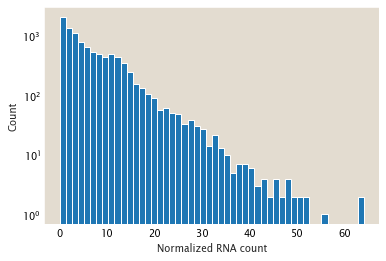

In [5]:
plt.hist(df['norm_ct_1'], bins=50)
plt.xlabel('Normalized RNA count')
plt.ylabel('Count')
plt.yscale('log')
plt.show()

In [6]:
n_seqs = len(df)
mut_list = df['seq'].values
mu_data = df['norm_ct_1']
nbins = 2
upper_bound = 5
footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, lacO1, nbins, upper_bound)

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (156,) and arg 1 with shape (154,).

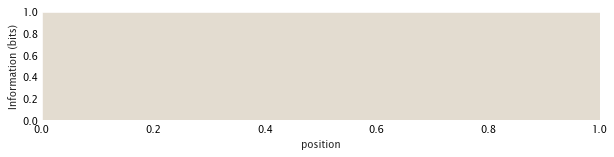

In [8]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 5
exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, lacO1, smoothed=True, windowsize=windowsize)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]

cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
footprint_smoothed = tregs.utils.smoothing(footprint, windowsize=windowsize)
ax.bar(x, footprint_smoothed, edgecolor=None, color=shiftcolors)

#plt.savefig('../figs/lacI_synthetic_footprint_5_15.png', dpi=300, bbox_inches='tight')
plt.show()

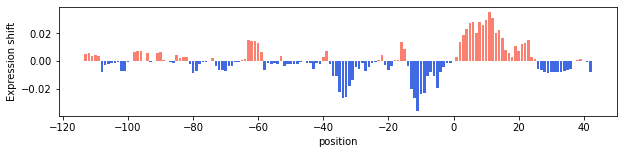

In [ ]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Expression shift')
ax.set_xlabel('position')

cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
ax.bar(x, exshift_list, edgecolor=None, color=shiftcolors)

#plt.savefig('../figs/lacI_synthetic_exshift_5_15.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
ep_wt = -2
er_wt = -15

df = tregs.simulate.simrep(lacO1, lacWT, O1, rnap_emat, O1_emat, 
                                ep_wt, er_wt, n_NS, n_p, n_r)
df.head()

,seq,pbound,ct_0,ct_1,ct,norm_ct_1
0,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.000091,1.764736,0.0,1.764736,0.000000
1,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.002559,1.248580,0.0,1.248580,0.000000
2,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.002678,9.752420,2.0,11.752420,0.205077
3,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.000879,4.465623,0.0,4.465623,0.000000
4,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.006125,28.112862,17.0,45.112862,0.604705


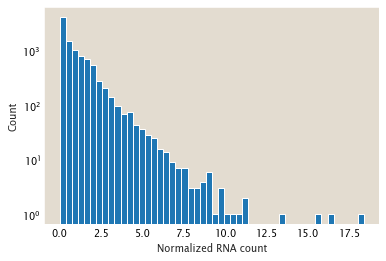

In [10]:
plt.hist(df['norm_ct_1'], bins=50)
plt.xlabel('Normalized RNA count')
plt.ylabel('Count')
plt.yscale('log')
plt.show()

In [14]:
n_seqs = len(df)
mut_list = df['seq'].values
mu_data = df['norm_ct_1']
nbins = 2
upper_bound = np.mean(mu_data)
footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, lacO1, nbins, upper_bound)

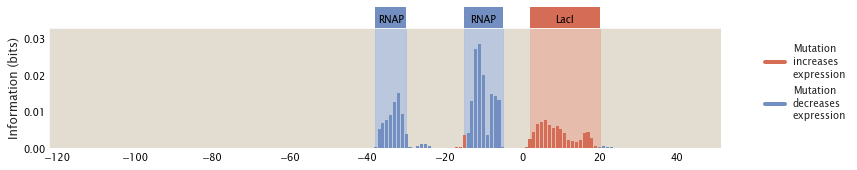

In [15]:
fig, ax = plt.subplots(figsize=(12,2.5))

ax.axvspan(-38, -30, alpha=0.7, color='#A9BFE3')
ax.axvspan(-15, -5, alpha=0.7, color='#A9BFE3')
ax.axvspan(2, 20, alpha=0.7, color='#E8B19D')

ax.set_ylim(top=max(footprint)*1.15)
ax.add_patch(mpl.patches.Rectangle((-38, max(footprint)*1.15),
                                        8,
                                        max(footprint) * 0.2,
                                        facecolor='#738FC1',
                                        clip_on=False,
                                        linewidth = 0))
ax.text(-38 + 0.5 * 8, max(footprint) * 1.2, 'RNAP', fontsize = 10, color = 'k',
         ha='center', va='baseline')

ax.add_patch(mpl.patches.Rectangle((-15, max(footprint)*1.15),
                                        10,
                                        max(footprint) * 0.2,
                                        facecolor='#738FC1',
                                        clip_on=False,
                                        linewidth = 0))
ax.text(-15 + 0.5 * 10, max(footprint) * 1.2, 'RNAP', fontsize = 10, color = 'k',
         ha='center', va='baseline')

ax.add_patch(mpl.patches.Rectangle((2, max(footprint)*1.15),
                                        18,
                                        max(footprint) * 0.2,
                                        facecolor='#D56C55',
                                        clip_on=False,
                                        linewidth = 0))
ax.text(2 + 0.5 * 18, max(footprint) * 1.2, 'LacI', fontsize = 10, color = 'k',
         ha='center', va='baseline')


windowsize=3
cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
shiftcolors = [('#D56C55' if exshift > 0 else '#738FC1') for exshift in exshift_list]
ax.bar(x, footprint, color=shiftcolors, edgecolor=None, linewidth=0)
ax.set_ylabel('Information (bits)', fontsize=12)

custom_lines = [Line2D([0], [0], color='#D56C55', lw=4),
                Line2D([0], [0], color='#738FC1', lw=4)]
plt.legend(custom_lines,
           ['Mutation\nincreases\nexpression', 'Mutation\ndecreases\nexpression'],
           bbox_to_anchor=(1.2, 0.95), frameon=False)

plt.tight_layout()
plt.savefig('../figs/simrep_footprint_weak_RNAP.png', dpi=300, bbox_inches='tight')
plt.show()

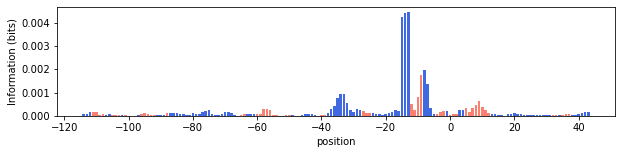

In [18]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 3
exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, lacO1, smoothed=True, windowsize=windowsize)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]

cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
footprint_smoothed = tregs.utils.smoothing(footprint, windowsize=windowsize)
ax.bar(x, footprint_smoothed, edgecolor=None, color=shiftcolors)

plt.savefig('../figs/lacI_synthetic_footprint_3_15.png', dpi=300, bbox_inches='tight')
plt.show()

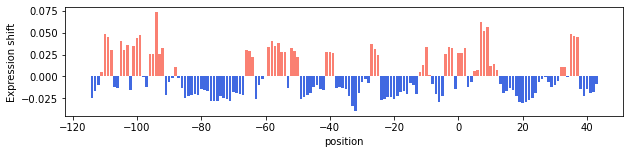

In [19]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Expression shift')
ax.set_xlabel('position')

cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
ax.bar(x, exshift_list, edgecolor=None, color=shiftcolors)

plt.savefig('../figs/lacI_synthetic_exshift_3_15.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
ep_wt = -5
er_wt = -25

df = tregs.simulate.simrep(lacO1, lacWT, O1, rnap_emat, O1_emat, 
                                ep_wt, er_wt, n_NS, n_p, n_r)
df.head()

,seq,pbound,ct_0,ct_1,ct,norm_ct_1
0,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,8.866722e-04,14.384290,1.0,15.384290,0.069520
1,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,2.396250e-04,3.379959,0.0,3.379959,0.000000
2,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,2.889300e-03,21.996623,6.0,27.996623,0.272769
3,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,2.418088e-07,2.317636,0.0,2.317636,0.000000
4,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,1.508447e-07,4.500975,0.0,4.500975,0.000000


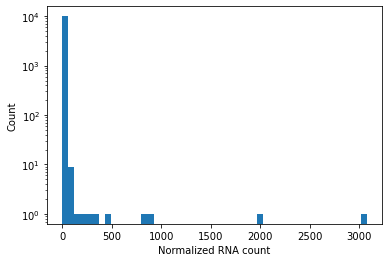

In [26]:
plt.hist(df['norm_ct_1'], bins=50)
plt.xlabel('Normalized RNA count')
plt.ylabel('Count')
plt.yscale('log')
plt.show()

In [17]:
n_seqs = len(df)
mut_list = df['seq'].values
mu_data = df['norm_ct_1']
nbins = 2
upper_bound = np.mean(mu_data)
footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, lacO1, nbins, upper_bound)

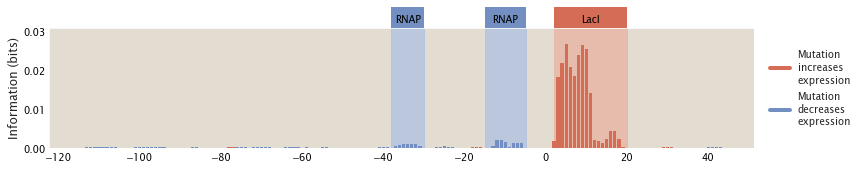

In [21]:
fig, ax = plt.subplots(figsize=(12,2.5))

ax.axvspan(-38, -30, alpha=0.7, color='#A9BFE3')
ax.axvspan(-15, -5, alpha=0.7, color='#A9BFE3')
ax.axvspan(2, 20, alpha=0.7, color='#E8B19D')

ax.set_ylim(top=max(footprint)*1.15)
ax.add_patch(mpl.patches.Rectangle((-38, max(footprint)*1.15),
                                        8,
                                        max(footprint) * 0.2,
                                        facecolor='#738FC1',
                                        clip_on=False,
                                        linewidth = 0))
ax.text(-38 + 0.5 * 8, max(footprint) * 1.2, 'RNAP', fontsize = 10, color = 'k',
         ha='center', va='baseline')

ax.add_patch(mpl.patches.Rectangle((-15, max(footprint)*1.15),
                                        10,
                                        max(footprint) * 0.2,
                                        facecolor='#738FC1',
                                        clip_on=False,
                                        linewidth = 0))
ax.text(-15 + 0.5 * 10, max(footprint) * 1.2, 'RNAP', fontsize = 10, color = 'k',
         ha='center', va='baseline')

ax.add_patch(mpl.patches.Rectangle((2, max(footprint)*1.15),
                                        18,
                                        max(footprint) * 0.2,
                                        facecolor='#D56C55',
                                        clip_on=False,
                                        linewidth = 0))
ax.text(2 + 0.5 * 18, max(footprint) * 1.2, 'LacI', fontsize = 10, color = 'k',
         ha='center', va='baseline')


windowsize=3
cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
shiftcolors = [('#D56C55' if exshift > 0 else '#738FC1') for exshift in exshift_list]
ax.bar(x, footprint, color=shiftcolors, edgecolor=None, linewidth=0)
ax.set_ylabel('Information (bits)', fontsize=12)

custom_lines = [Line2D([0], [0], color='#D56C55', lw=4),
                Line2D([0], [0], color='#738FC1', lw=4)]
plt.legend(custom_lines,
           ['Mutation\nincreases\nexpression', 'Mutation\ndecreases\nexpression'],
           bbox_to_anchor=(1.15, 0.9), frameon=False)

plt.tight_layout()
plt.savefig('../figs/simrep_footprint_strong_rep.png', dpi=300, bbox_inches='tight')
plt.show()

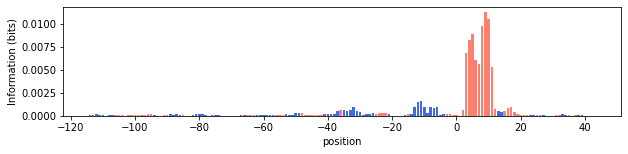

In [29]:
fig, ax = plt.subplot(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 3
exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, lacO1, smoothed=True, windowsize=windowsize)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]

cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
footprint_smoothed = tregs.utils.smoothing(footprint, windowsize=windowsize)
ax.bar(x, footprint_smoothed, edgecolor=None, color=shiftcolors)

plt.savefig('../figs/lacI_synthetic_footprint_5_25.png', dpi=300, bbox_inches='tight')
plt.show()

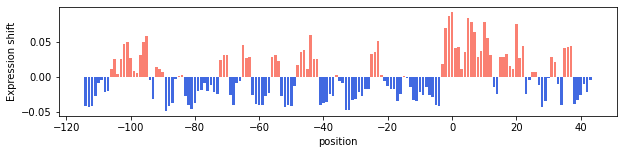

In [30]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Expression shift')
ax.set_xlabel('position')

cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
ax.bar(x, exshift_list, edgecolor=None, color=shiftcolors)

plt.savefig('../figs/lacI_synthetic_exshift_5_25.png', dpi=300, bbox_inches='tight')
plt.show()